In [1]:
import numpy as np
import xarray as xr
import pandas as pd
import glob, os
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.gridspec as gridspec
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from itertools import chain
import copy
import colormath, colormath.color_objects, colormath.color_conversions
from colormath.color_objects import sRGBColor
import urllib
import re
%matplotlib inline

In [26]:
# Specify years to include in the statistics
years = [2014]

# Sepcify directory of the MCS track stats file
rootdir = '/pscratch/sd/f/feng045/iclass/amazon_hvmixing/'
files_obs = []
files_m1 = []
files_m2 = []
files_m3 = []
for yy in years:
    files_obs = files_obs + sorted(glob.glob(f'{rootdir}gpm/stats/monthly/mcs_rainmap_{yy}*.nc'))
    files_m1 = files_m1 + sorted(glob.glob(f'{rootdir}CONTROLRUN/TRACK_DIR_REGRID/stats/monthly/mcs_rainmap_{yy}*.nc'))
    files_m2 = files_m2 + sorted(glob.glob(f'{rootdir}HVMIXINGRUN10/TRACK_DIR_REGRID/stats/monthly/mcs_rainmap_{yy}*.nc'))
    files_m3 = files_m3 + sorted(glob.glob(f'{rootdir}HVMIXINGRUN15/TRACK_DIR_REGRID/stats/monthly/mcs_rainmap_{yy}*.nc'))
nyears_obs = len(files_obs)
nyears_m1 = len(files_m1)
nyears_m2 = len(files_m2)
nyears_m3 = len(files_m3)
print(f'Number of files (OBS): {nyears_obs}')
print(f'Number of files (CTL): {nyears_m1}')
print(f'Number of files (HV10): {nyears_m2}')
print(f'Number of files (HV15): {nyears_m3}')

topfile = '/global/cfs/projectdirs/m1657/zfeng/SAAG/map_data/wrf_landmask_reg2imerg.nc'

# Output figure directory
figdir = f'/global/cfs/cdirs/m1657/zfeng/amazon_hvmixing/figures/'
os.makedirs(figdir, exist_ok=True)
print(figdir)

Number of files (OBS): 1
Number of files (CTL): 1
Number of files (HV10): 1
Number of files (HV15): 1
/global/cfs/cdirs/m1657/zfeng/amazon_hvmixing/figures/


In [27]:
# Read topography data
dstop = xr.open_dataset(topfile)
# Convert surface geopotential to height in meters
ter = dstop.HGT.squeeze()
landmask = dstop.LANDMASK.squeeze()
ter_s = gaussian_filter(ter, 1)
lon_ter = dstop.lon
lat_ter = dstop.lat
dstop

<xarray.Dataset>
Dimensions:   (lat: 690, lon: 480, nbnd: 2)
Coordinates:
  * lat       (lat) float64 -55.95 -55.85 -55.75 -55.65 ... 12.75 12.85 12.95
  * lon       (lon) float64 278.1 278.2 278.2 278.4 ... 325.7 325.8 325.9 326.0
Dimensions without coordinates: nbnd
Data variables:
    lat_bnds  (lat, nbnd) float64 ...
    lon_bnds  (lon, nbnd) float64 ...
    gw        (lat) float64 ...
    area      (lat, lon) float64 ...
    HGT       (lat, lon) float32 ...
    LAKEMASK  (lat, lon) float32 ...
    LANDMASK  (lat, lon) float32 ...
    LU_INDEX  (lat, lon) float32 ...
    XTIME     datetime64[ns] ...
Attributes: (12/154)
    TITLE:                            OUTPUT FROM WRF V4.1.5 MODEL
    START_DATE:                      2018-06-01_00:00:00
    SIMULATION_START_DATE:           2018-06-01_00:00:00
    WEST-EAST_GRID_DIMENSION:        1472
    SOUTH-NORTH_GRID_DIMENSION:      2028
    BOTTOM-TOP_GRID_DIMENSION:       61
    ...                              ...
    history:                         Wed Jun  9 11:51:55 2021: ncks -O -t 1 -...
    remap_script:                    ncremap
    remap_hostname:                  cori04
    remap_version:                   4.7.9
    map_file:                        weight_wrf_imerg_conserve.nc
    input_file:                      /global/cscratch1/sd/feng045/SAAG/map_da...

## Custom functions to use NCL colormaps

In [3]:
color_obj_dict = {'sRGB':colormath.color_objects.sRGBColor,
                  'HSV':colormath.color_objects.HSVColor,
                  'Lab':colormath.color_objects.LabColor,
                  'LCHuv':colormath.color_objects.LCHuvColor,
                  'LCHab':colormath.color_objects.LCHabColor,
                  'XYZ':colormath.color_objects.XYZColor}

def __rgb_to_array(rgb_color):
    r = np.minimum(1, round(rgb_color.rgb_r*10000)/10000)
    g = np.minimum(1, round(rgb_color.rgb_g*10000)/10000)
    b = np.minimum(1, round(rgb_color.rgb_b*10000)/10000)
    return r,g,b


def create_palette(start_rgb, end_rgb, n, colorspace):
    # convert start and end to a point in the given colorspace
    start = colormath.color_conversions.convert_color(start_rgb, colorspace).get_value_tuple()
    end = colormath.color_conversions.convert_color(end_rgb, colorspace).get_value_tuple()

    # create a set of n points along start to end
    points = list(zip(*[np.linspace(start[i], end[i], n) for i in range(3)]))

    # create a color for each point and convert back to rgb
    rgb_colors = [colormath.color_conversions.convert_color(colorspace(*point), sRGBColor) for point in points]

    # finally convert rgb colors back to hex
    return [__rgb_to_array(color) for color in  rgb_colors]


def __retrive_NCL_webcontent(cmapname):
    target_url = 'https://www.ncl.ucar.edu/Document/Graphics/ColorTables/Files/%s.rgb' % cmapname
    request = urllib.request.urlopen(target_url)
    return request


def __collect_discrete_NCL_cmap(cmapname):
    rawdata = __retrive_NCL_webcontent(cmapname)
    
    cmap_color_list = list()
    
    color_section_sig = 0
    
    for line in rawdata:
        
        line_decode = line.decode('utf-8')
        info = re.split('\s+', line_decode.replace('\n','').replace('^\s+',''))

        if color_section_sig==1:
            if info[0]=='' and len(info)>=3:
                if np.maximum(np.maximum(float(info[1]), float(info[2])), float(info[3]))>1:
                    cmap_color_list.append((float(info[1])/255, float(info[2])/255, float(info[3])/255))
                else:
                    cmap_color_list.append((float(info[1]), float(info[2]), float(info[3])))
            if len(info)==3:
                if ';' in info[0] or '#' in info[0]:
                    whatisthis = 's'
                else:
                    if np.maximum(np.maximum(float(info[0]), float(info[1])), float(info[2]))>1:
                        cmap_color_list.append((float(info[0])/255, float(info[1])/255, float(info[2])/255))
                    else:
                        cmap_color_list.append((float(info[0]), float(info[1]), float(info[2])))
        
        if 'ncolors' in str(info[0]):
            color_section_sig = 1  # meaning now we are at color lines (or "r g b" line)

    return cmap_color_list


def __cmap_refinement(raw_cmap_rgb, n_interpolate=10, workspace=color_obj_dict['sRGB']):
    # workspace:  choose which color space the refinement is conducted.
    #             refer to https://stackoverflow.com/questions/55032648/given-a-start-color-and-a-middle-color-how-to-get-the-remaining-colors-python

    n_in = len(raw_cmap_rgb)

    new_array = list()

    for i in np.arange(n_in-1):
        out_colors = create_palette(sRGBColor(*raw_cmap_rgb[i], is_upscaled=False), sRGBColor(*raw_cmap_rgb[i+1], is_upscaled=False), n_interpolate+1, workspace)
        for j in np.arange(len(out_colors)-1):
            new_array.append(out_colors[j])

    return new_array


def generate_NCL_cmap(cmapname, cont_opt=False, cont_param_n=10, cont_param_ws='sRGB',
                      white_first=False, white_ext=False, reverse_cmap=False):
    # description:
    #     cmapname:      taken as shown on the NCL website
    #     cont_opt:      to convert the discreate colormap to continuous colormap
    #     cont_param_n:  how many "intermediate" colors to be inserted to the nearby discreate colors
    #     cont_param_ws: color space to conduct interploation. Default to "sRGB", which should work for most cases
    #     white_first:   whether to set the first color as white. May be useful if the minimum does not mean anything
    #     white_ext:     whether to add this above white as an extended color (when set to True), or just replace the first color (when set to False).
    #     reverse_cmap:  similar to "_r" in colormap.
    # note:  reverse_cmap is applied first, then white_first option.

    cmap_discrete_raw = __collect_discrete_NCL_cmap(cmapname)

    if reverse_cmap==True:
        cmap_discrete_raw.reverse()

    if white_first==True:
        if white_ext==True:
            cmap_discrete = list()
            cmap_discrete.append((1,1,1))
            for i in np.arange(len(cmap_discrete_raw)):
                cmap_discrete.append(cmap_discrete_raw[int(i)])
        else:
            cmap_discrete = cmap_discrete_raw.copy()
        cmap_discrete[0] = (1,1,1)
    else:
        cmap_discrete = cmap_discrete_raw

    if cont_opt==False:
        out_cmap = cmap_discrete

    if cont_opt==True:
        out_cmap = __cmap_refinement(cmap_discrete, n_interpolate=cont_param_n, workspace=color_obj_dict[cont_param_ws])

    return mpl.colors.ListedColormap(out_cmap)

def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=256):
    """ Truncate colormap.
    """
    new_cmap = mpl.colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

In [4]:
# Read OBS rain map files
dsobs = xr.open_mfdataset(files_obs, concat_dim='time', combine='nested')
lon = dsobs.lon
lat = dsobs.lat
dsobs.load()

<xarray.Dataset>
Dimensions:                        (time: 1, lat: 327, lon: 480)
Coordinates:
  * time                           (time) datetime64[ns] 2014-04-01
  * lat                            (lat) float64 -19.75 -19.65 ... 12.75 12.85
  * lon                            (lon) float64 -81.95 -81.85 ... -34.15 -34.05
Data variables:
    longitude                      (time, lat, lon) float32 -81.95 ... -34.05
    latitude                       (time, lat, lon) float32 -19.75 ... 12.85
    precipitation                  (time, lat, lon) float32 4.469 ... 0.1753
    mcs_precipitation              (time, lat, lon) float32 0.0 0.0 ... 0.0 0.0
    idc_precipitation              (time, lat, lon) float32 0.0 0.0 ... 0.0 0.0
    congestus_precipitation        (time, lat, lon) float32 0.0 0.0 ... 0.0 0.0
    mcs_precipitation_count        (time, lat, lon) float32 0.0 0.0 ... 0.0 0.0
    idc_precipitation_count        (time, lat, lon) float32 0.0 0.0 ... 0.0 0.0
    congestus_precipitation_count  (time, lat, lon) float32 0.0 0.0 ... 0.0 0.0
    ntimes                         (time) float32 696.0
Attributes:
    title:       Monthly precipitation accumulation
    contact:     Zhe Feng, zhe.feng@pnnl.gov
    created_on:  Wed Jun 28 13:40:05 2023

In [5]:
# Read CTL rain map files
dsm1 = xr.open_mfdataset(files_m1, concat_dim='time', combine='nested')
dsm1.load()

<xarray.Dataset>
Dimensions:                        (time: 1, lat: 327, lon: 480)
Coordinates:
  * time                           (time) datetime64[ns] 2014-04-01
  * lat                            (lat) float32 -19.75 -19.65 ... 12.75 12.85
  * lon                            (lon) float32 -81.95 -81.85 ... -34.15 -34.05
Data variables:
    longitude                      (time, lat, lon) float32 -81.95 ... -34.05
    latitude                       (time, lat, lon) float32 -19.75 ... 12.85
    precipitation                  (time, lat, lon) float32 0.0 0.0 ... 0.0 0.0
    mcs_precipitation              (time, lat, lon) float32 0.0 0.0 ... 0.0 0.0
    idc_precipitation              (time, lat, lon) float32 0.0 0.0 ... 0.0 0.0
    congestus_precipitation        (time, lat, lon) float32 0.0 0.0 ... 0.0 0.0
    mcs_precipitation_count        (time, lat, lon) float32 0.0 0.0 ... 0.0 0.0
    idc_precipitation_count        (time, lat, lon) float32 0.0 0.0 ... 0.0 0.0
    congestus_precipitation_count  (time, lat, lon) float32 0.0 0.0 ... 0.0 0.0
    ntimes                         (time) float32 696.0
Attributes:
    title:       Monthly precipitation accumulation
    contact:     Zhe Feng, zhe.feng@pnnl.gov
    created_on:  Wed Jun 28 13:41:48 2023

In [6]:
# Read m2 rain map files
dsm2 = xr.open_mfdataset(files_m2, concat_dim='time', combine='nested').load()

In [7]:
# Read m3 rain map files
dsm3 = xr.open_mfdataset(files_m3, concat_dim='time', combine='nested').load()

In [8]:
# Total number of hours
nhours_obs = dsobs.ntimes.sum(dim='time').data
# Sum monthly precipitation amount [mm], divided by total number of hours to get [mm/h]
# then x24 to get [mm/day]
totpcp_all_obs = 24. * dsobs.precipitation.sum(dim='time') / nhours_obs
mcspcp_all_obs = 24. * dsobs.mcs_precipitation.sum(dim='time') / nhours_obs
idcpcp_all_obs = 24. * dsobs.idc_precipitation.sum(dim='time') / nhours_obs
congpcp_all_obs = 24. * dsobs.congestus_precipitation.sum(dim='time') / nhours_obs

mcspcpfrac_all_obs = 100. * mcspcp_all_obs / totpcp_all_obs
idcpcpfrac_all_obs = 100. * idcpcp_all_obs / totpcp_all_obs
congpcpfrac_all_obs = 100. * congpcp_all_obs / totpcp_all_obs

# Calculate number of precipitation hours
mcshour_all_obs = dsobs.mcs_precipitation_count.sum(dim='time')
idchour_all_obs = dsobs.idc_precipitation_count.sum(dim='time')
conghour_all_obs = dsobs.congestus_precipitation_count.sum(dim='time')
# Precipitation frequency
mcspcpfreq_all_obs = 100 * mcshour_all_obs / nhours_obs
idcpcpfreq_all_obs = 100 * idchour_all_obs / nhours_obs
congpcpfreq_all_obs = 100 * conghour_all_obs / nhours_obs
# Mean precipiation intensity
mcspcpintensity_all_obs = dsobs.mcs_precipitation.sum(dim='time') / mcshour_all_obs
idcpcpintensity_all_obs = dsobs.idc_precipitation.sum(dim='time') / idchour_all_obs
congpcpintensity_all_obs = dsobs.congestus_precipitation.sum(dim='time') / conghour_all_obs

In [9]:
# Total number of hours
nhours_m1 = dsm1.ntimes.sum(dim='time').data
# Sum monthly precipitation amount [mm], divided by total number of hours to get [mm/h]
# then x24 to get [mm/day]
totpcp_all_m1 = 24. * dsm1.precipitation.sum(dim='time') / nhours_m1
mcspcp_all_m1 = 24. * dsm1.mcs_precipitation.sum(dim='time') / nhours_m1
idcpcp_all_m1 = 24. * dsm1.idc_precipitation.sum(dim='time') / nhours_m1
congpcp_all_m1 = 24. * dsm1.congestus_precipitation.sum(dim='time') / nhours_m1

mcspcpfrac_all_m1 = 100. * mcspcp_all_m1 / totpcp_all_m1
idcpcpfrac_all_m1 = 100. * idcpcp_all_m1 / totpcp_all_m1
congpcpfrac_all_m1 = 100. * congpcp_all_m1 / totpcp_all_m1

# Calculate number of precipitation hours
mcshour_all_m1 = dsm1.mcs_precipitation_count.sum(dim='time')
idchour_all_m1 = dsm1.idc_precipitation_count.sum(dim='time')
conghour_all_m1 = dsm1.congestus_precipitation_count.sum(dim='time')
# Precipitation frequency
mcspcpfreq_all_m1 = 100 * mcshour_all_m1 / nhours_m1
idcpcpfreq_all_m1 = 100 * idchour_all_m1 / nhours_m1
congpcpfreq_all_m1 = 100 * conghour_all_m1 / nhours_m1
# Mean precipiation intensity
mcspcpintensity_all_m1 = dsm1.mcs_precipitation.sum(dim='time') / mcshour_all_m1
idcpcpintensity_all_m1 = dsm1.idc_precipitation.sum(dim='time') / idchour_all_m1
congpcpintensity_all_m1 = dsm1.congestus_precipitation.sum(dim='time') / conghour_all_m1

In [10]:
# Total number of hours
nhours_m2 = dsm2.ntimes.sum(dim='time').data
# Sum monthly precipitation amount [mm], divided by total number of hours to get [mm/h]
# then x24 to get [mm/day]
totpcp_all_m2 = 24. * dsm2.precipitation.sum(dim='time') / nhours_m2
mcspcp_all_m2 = 24. * dsm2.mcs_precipitation.sum(dim='time') / nhours_m2
idcpcp_all_m2 = 24. * dsm2.idc_precipitation.sum(dim='time') / nhours_m2
congpcp_all_m2 = 24. * dsm2.congestus_precipitation.sum(dim='time') / nhours_m2

mcspcpfrac_all_m2 = 100. * mcspcp_all_m2 / totpcp_all_m2
idcpcpfrac_all_m2 = 100. * idcpcp_all_m2 / totpcp_all_m2
congpcpfrac_all_m2 = 100. * congpcp_all_m2 / totpcp_all_m2

# Calculate number of precipitation hours
mcshour_all_m2 = dsm2.mcs_precipitation_count.sum(dim='time')
idchour_all_m2 = dsm2.idc_precipitation_count.sum(dim='time')
conghour_all_m2 = dsm2.congestus_precipitation_count.sum(dim='time')
# Precipitation frequency
mcspcpfreq_all_m2 = 100 * mcshour_all_m2 / nhours_m2
idcpcpfreq_all_m2 = 100 * idchour_all_m2 / nhours_m2
congpcpfreq_all_m2 = 100 * conghour_all_m2 / nhours_m2
# Mean precipiation intensity
mcspcpintensity_all_m2 = dsm2.mcs_precipitation.sum(dim='time') / mcshour_all_m2
idcpcpintensity_all_m2 = dsm2.idc_precipitation.sum(dim='time') / idchour_all_m2
congpcpintensity_all_m2 = dsm2.congestus_precipitation.sum(dim='time') / conghour_all_m2

In [11]:
# Total number of hours
nhours_m3 = dsm3.ntimes.sum(dim='time').data
# Sum monthly precipitation amount [mm], divided by total number of hours to get [mm/h]
# then x24 to get [mm/day]
totpcp_all_m3 = 24. * dsm3.precipitation.sum(dim='time') / nhours_m3
mcspcp_all_m3 = 24. * dsm3.mcs_precipitation.sum(dim='time') / nhours_m3
idcpcp_all_m3 = 24. * dsm3.idc_precipitation.sum(dim='time') / nhours_m3
congpcp_all_m3 = 24. * dsm3.congestus_precipitation.sum(dim='time') / nhours_m3

mcspcpfrac_all_m3 = 100. * mcspcp_all_m3 / totpcp_all_m3
idcpcpfrac_all_m3 = 100. * idcpcp_all_m3 / totpcp_all_m3
congpcpfrac_all_m3 = 100. * congpcp_all_m3 / totpcp_all_m3

# Calculate number of precipitation hours
mcshour_all_m3 = dsm3.mcs_precipitation_count.sum(dim='time')
idchour_all_m3 = dsm3.idc_precipitation_count.sum(dim='time')
conghour_all_m3 = dsm3.congestus_precipitation_count.sum(dim='time')
# Precipitation frequency
mcspcpfreq_all_m3 = 100 * mcshour_all_m3 / nhours_m3
idcpcpfreq_all_m3 = 100 * idchour_all_m3 / nhours_m3
congpcpfreq_all_m3 = 100 * conghour_all_m3 / nhours_m3
# Mean precipiation intensity
mcspcpintensity_all_m3 = dsm3.mcs_precipitation.sum(dim='time') / mcshour_all_m3
idcpcpintensity_all_m3 = dsm3.idc_precipitation.sum(dim='time') / idchour_all_m3
congpcpintensity_all_m3 = dsm3.congestus_precipitation.sum(dim='time') / conghour_all_m3

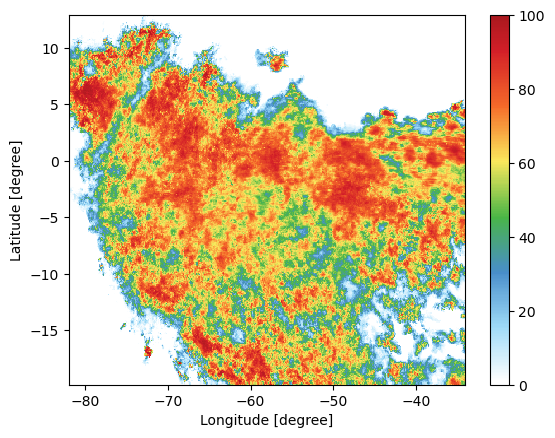

In [12]:
cmap = generate_NCL_cmap('WhiteBlueGreenYellowRed', cont_opt=False, cont_param_n=0, cont_param_ws='sRGB', white_first=True, white_ext=True)
cmap = truncate_colormap(cmap, 0.0, 0.95)
mcspcpfrac_all_obs.plot(vmin=0, vmax=100, cmap=cmap)

## Plotting Function

In [100]:
def plot_map_mxn(nrows, ncols, dataarray, lonarray, latarray, levels, cmaps, titles, cblabels, cbticks, figname, 
                 oob_colors=None, figsize=None, boxes=None):
    
    mpl.rcParams['font.size'] = 12
    mpl.rcParams['font.family'] = 'Helvetica'

    map_extent = [-82, -34, -20, 13]
    lonv = np.arange(-80,-30.1,10)
    latv = np.arange(-20,10.1,10)
    proj = ccrs.PlateCarree()
    data_proj = ccrs.PlateCarree()
    levelshgt = [1000,6000]
    resolution = '50m'
    land = cfeature.NaturalEarthFeature('physical', 'land', resolution)
    ocean = cfeature.NaturalEarthFeature('physical', 'ocean', resolution)
    borders = cfeature.NaturalEarthFeature('cultural', 'admin_0_boundary_lines_land', resolution)
    rivers = cfeature.NaturalEarthFeature(category='physical', name='rivers_lake_centerlines', scale=resolution)

    fig, axs = plt.subplots(nrows, ncols, figsize=figsize, dpi=100, subplot_kw=dict(projection=proj))
    
    for row in range(0, nrows):
        for col in range(0, ncols):
            ax = axs[row, col]
            ax.set_extent(map_extent, crs=proj)
            # ax.add_feature(borders, edgecolor='k', facecolor='none', linewidth=0.8, zorder=3)
            ax.add_feature(land, facecolor='none', edgecolor='k', lw=2, zorder=3)
            ax.add_feature(rivers, facecolor='none', edgecolor='k', zorder=3)
            ax.set_title(titles[row][col], loc='left')
            ax.set_aspect('auto', adjustable=None)
            ax.set_title(titles[row][col], loc='left')

            # Plot grid lines and lat/lon labels
            gl = ax.gridlines(crs=proj, draw_labels=False, linestyle='--', linewidth=0.5)
            gl.xlocator = mpl.ticker.FixedLocator(lonv)
            gl.ylocator = mpl.ticker.FixedLocator(latv)        
            ax.set_xticks(lonv, crs=ccrs.PlateCarree())
            lon_formatter = LongitudeFormatter(zero_direction_label=True)
            lat_formatter = LatitudeFormatter()        
            ax.xaxis.set_major_formatter(lon_formatter)
            ax.set_yticks(latv, crs=ccrs.PlateCarree())
            ax.yaxis.set_major_formatter(lat_formatter)            

            data = dataarray[row][col]
            Zm = np.ma.masked_where(((np.isnan(data))), data)
            cmap = copy.copy(mpl.colormaps.get_cmap(cmaps[row][col]))
            # Set out-of-bounds colors
            if (oob_colors is not None) and (row == 0):
                cmap.set_over(oob_colors['over'])
                cmap.set_under(oob_colors['under'])
            norm = mpl.colors.BoundaryNorm(boundaries=levels[row][col], ncolors=cmap.N)
            cf1 = ax.pcolormesh(lonarray, latarray, Zm, shading='auto', norm=norm, cmap=cmap, transform=proj, zorder=2)
            cb1 = plt.colorbar(cf1, ax=ax, label=cblabels[row][col], pad=0.02, ticks=cbticks[row][col], extend='both', aspect=30)

            # Terrain height
            ct = ax.contour(lon_ter, lat_ter, ter, levels=levelshgt, \
                            colors='dimgray', linewidths=1., transform=proj, zorder=3)
            if boxes is not None:
                # Define the vertices of the rectangle in the projection coordinates
                x1, y1 = proj.transform_point(boxes['bounds'][0], boxes['bounds'][2], data_proj)
                x2, y2 = proj.transform_point(boxes['bounds'][1], boxes['bounds'][3], data_proj)
                # Plot rectangle
                ax.add_patch(
                    mpl.patches.Rectangle((x1, y1), x2-x1, y2-y1, transform=proj, fill=None, lw=2, 
                                          edgecolor=boxes['color'], zorder=4)
                )

    # Work around to make tight_layout work 
    fig.canvas.draw()
    fig.tight_layout(w_pad=0.15)
    fig.savefig(figname, dpi=300, bbox_inches='tight', facecolor='w')
    return fig

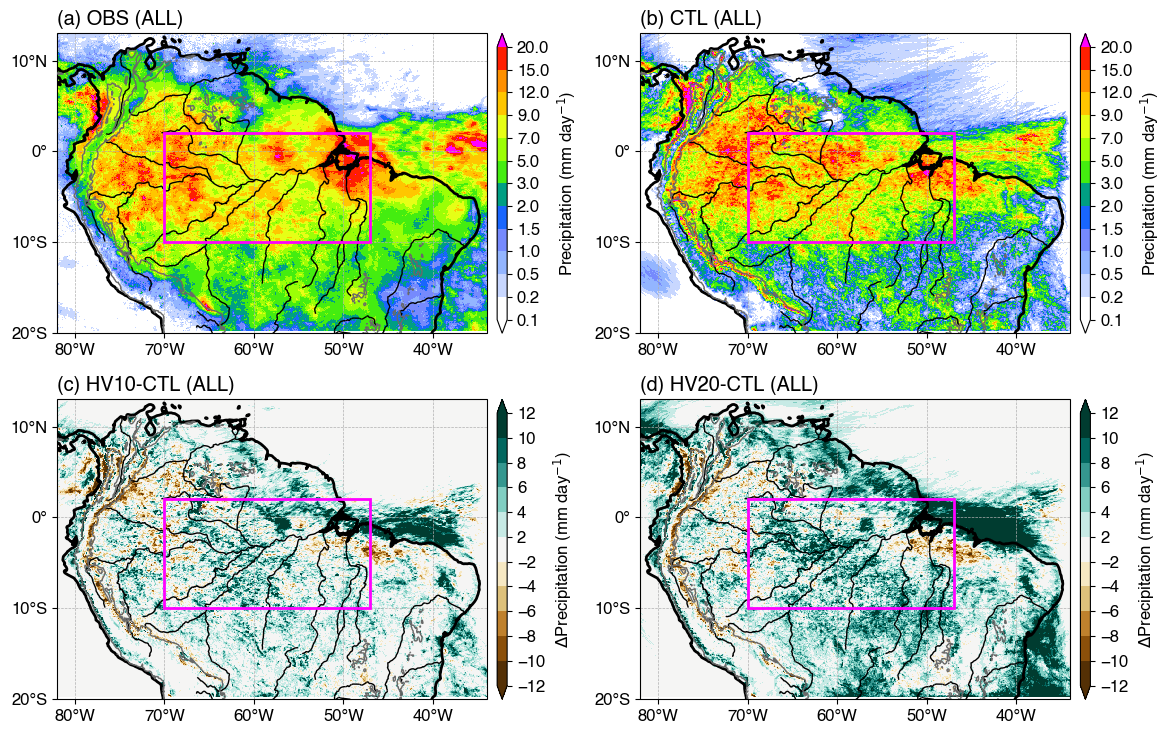

In [109]:
diff_m2_m1 = totpcp_all_m2 - totpcp_all_m1
diff_m3_m1 = totpcp_all_m3 - totpcp_all_m1
dataarray = [
    [totpcp_all_obs, totpcp_all_m1], 
    [diff_m2_m1, diff_m3_m1],
]
levels = [0.1,0.2,0.5,1,1.5,2,3,5,7,9,12,15,20]
levelsdiff = np.arange(-12,12.1,2)
# Remove mid-point (0 value)
idx = int((len(levelsdiff)-1)/2)
levelsdiff = np.delete(levelsdiff, idx)
levels = [[levels, levels], [levelsdiff,levelsdiff]]
cmap = generate_NCL_cmap('precip3_16lev', cont_opt=True, cont_param_n=16, cont_param_ws='sRGB')
cmapdiff = copy.copy(mpl.colormaps.get_cmap('BrBG'))
cmaps = [[cmap,cmap], [cmapdiff,cmapdiff]]
titles = [[f'(a) OBS (ALL)', f'(b) CTL (ALL)'], [f'(c) HV10-CTL (ALL)', f'(d) HV20-CTL (ALL)']]
cblabels = [['Precipitation (mm day$^{-1}$)','Precipitation (mm day$^{-1}$)'],
            [r'$\Delta$'+'Precipitation (mm day$^{-1}$)',r'$\Delta$'+'Precipitation (mm day$^{-1}$)']]
cbticks = levels
figname = f'{figdir}map_total_rainamount_obs_ctl_hv10_hv20.png'
oob_colors = {'under':'white', 'over':'magenta'}
# bounds = [-70.0, -50.0, -10.0, 2.0]
bounds = [-70.0, -47.0, -10.0, 2.0]
boxes = {
    'bounds': bounds,
    'color': 'magenta',
}
fig = plot_map_mxn(2, 2, dataarray, lon, lat, levels, cmaps, titles, cblabels, cbticks, figname, 
                   figsize=[12,7.5], oob_colors=oob_colors, boxes=boxes)

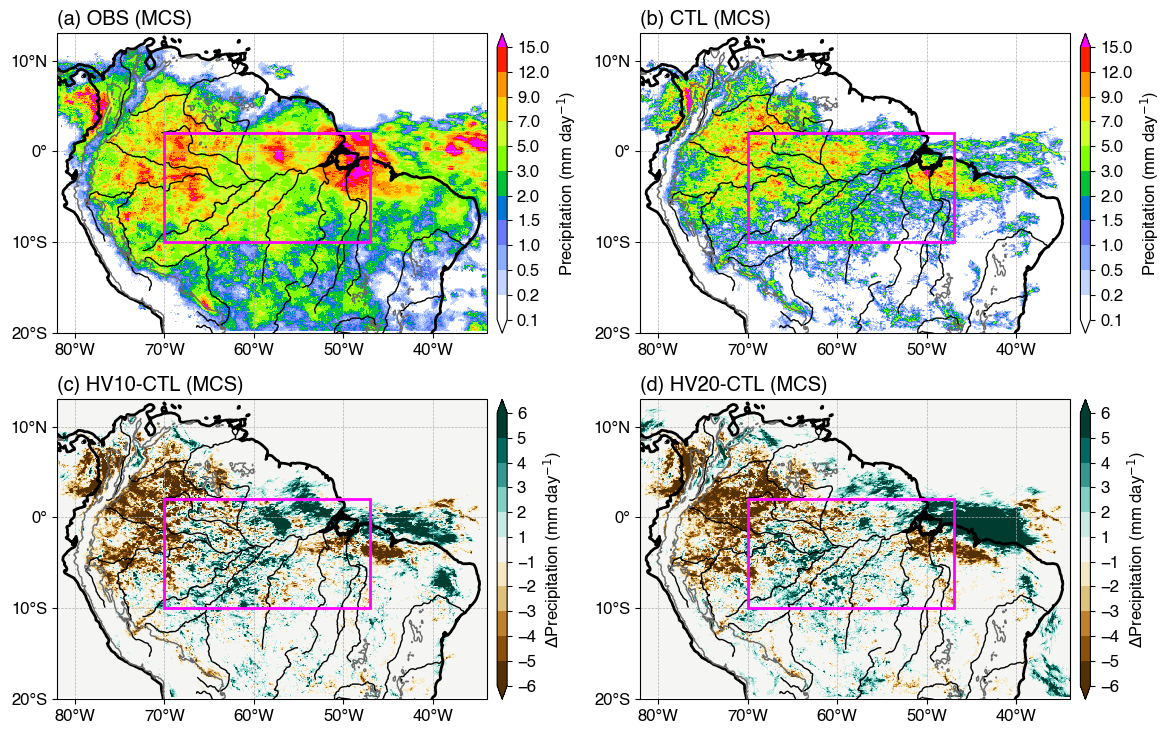

In [110]:
diff_m2_m1 = mcspcp_all_m2 - mcspcp_all_m1
diff_m3_m1 = mcspcp_all_m3 - mcspcp_all_m1
dataarray = [
    [mcspcp_all_obs, mcspcp_all_m1], 
    [diff_m2_m1, diff_m3_m1],
]
levels = [0.1,0.2,0.5,1,1.5,2,3,5,7,9,12,15]
# levelsdiff = np.arange(-12,12.1,2)
levelsdiff = np.arange(-6,6.1,1)
# Remove mid-point (0 value)
idx = int((len(levelsdiff)-1)/2)
levelsdiff = np.delete(levelsdiff, idx)
levels = [[levels, levels], [levelsdiff,levelsdiff]]
cmap = generate_NCL_cmap('precip3_16lev', cont_opt=True, cont_param_n=16, cont_param_ws='sRGB')
cmapdiff = copy.copy(mpl.colormaps.get_cmap('BrBG'))
cmaps = [[cmap,cmap], [cmapdiff,cmapdiff]]
titles = [[f'(a) OBS (MCS)', f'(b) CTL (MCS)'], [f'(c) HV10-CTL (MCS)', f'(d) HV20-CTL (MCS)']]
cblabels = [['Precipitation (mm day$^{-1}$)','Precipitation (mm day$^{-1}$)'],
            [r'$\Delta$'+'Precipitation (mm day$^{-1}$)',r'$\Delta$'+'Precipitation (mm day$^{-1}$)']]
cbticks = levels
figname = f'{figdir}map_mcs_rainamount_obs_ctl_hv10_hv20.png'
oob_colors = {'under':'white', 'over':'magenta'}
fig = plot_map_mxn(2, 2, dataarray, lon, lat, levels, cmaps, titles, cblabels, cbticks, figname, 
                   figsize=[12,7.5], oob_colors=oob_colors, boxes=boxes)

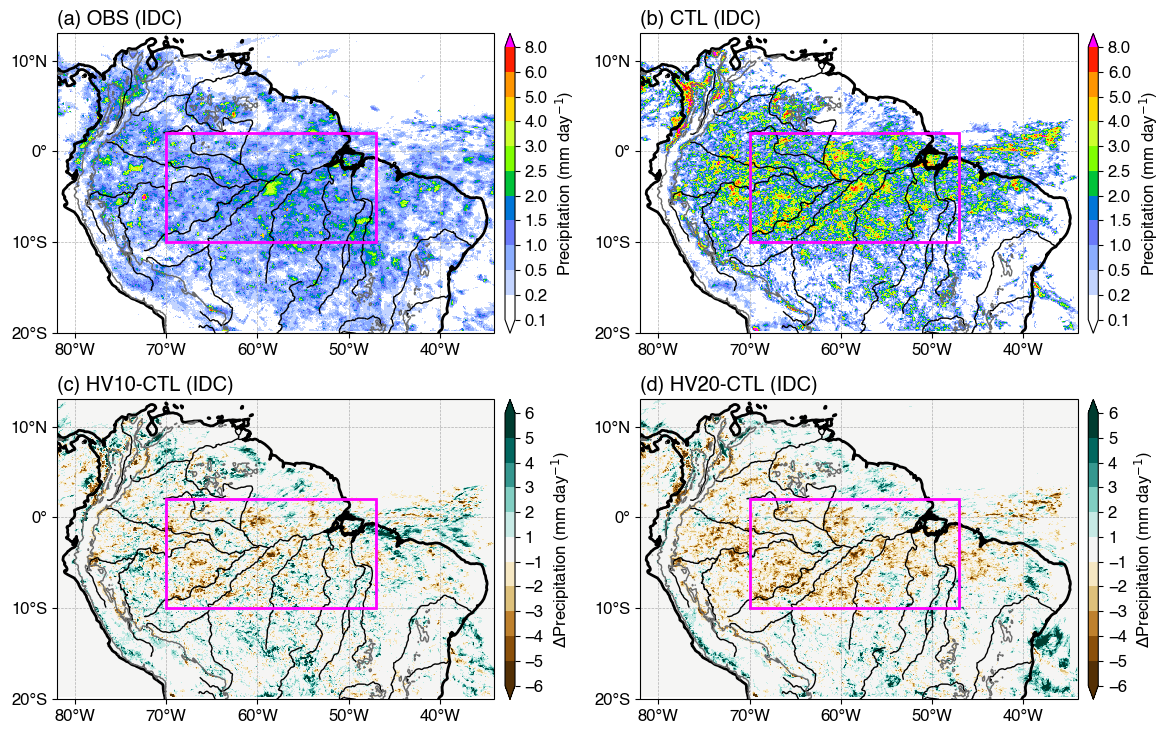

In [111]:
diff_m2_m1 = idcpcp_all_m2 - idcpcp_all_m1
diff_m3_m1 = idcpcp_all_m3 - idcpcp_all_m1
dataarray = [
    [idcpcp_all_obs, idcpcp_all_m1], 
    [diff_m2_m1, diff_m3_m1],
]
levels = [0.1,0.2,0.5,1,1.5,2,2.5,3,4,5,6,8]
levelsdiff = np.arange(-6,6.1,1)
# Remove mid-point (0 value)
idx = int((len(levelsdiff)-1)/2)
levelsdiff = np.delete(levelsdiff, idx)
levels = [[levels, levels], [levelsdiff,levelsdiff]]
cmap = generate_NCL_cmap('precip3_16lev', cont_opt=True, cont_param_n=16, cont_param_ws='sRGB')
cmapdiff = copy.copy(mpl.colormaps.get_cmap('BrBG'))
cmaps = [[cmap,cmap], [cmapdiff,cmapdiff]]
titles = [[f'(a) OBS (IDC)', f'(b) CTL (IDC)'], [f'(c) HV10-CTL (IDC)', f'(d) HV20-CTL (IDC)']]
cblabels = [['Precipitation (mm day$^{-1}$)','Precipitation (mm day$^{-1}$)'],
            [r'$\Delta$'+'Precipitation (mm day$^{-1}$)',r'$\Delta$'+'Precipitation (mm day$^{-1}$)']]
cbticks = levels
figname = f'{figdir}map_idc_rainamount_obs_ctl_hv10_hv20.png'
oob_colors = {'under':'white', 'over':'magenta'}
fig = plot_map_mxn(2, 2, dataarray, lon, lat, levels, cmaps, titles, cblabels, cbticks, figname, 
                   figsize=[12,7.5], oob_colors=oob_colors, boxes=boxes)

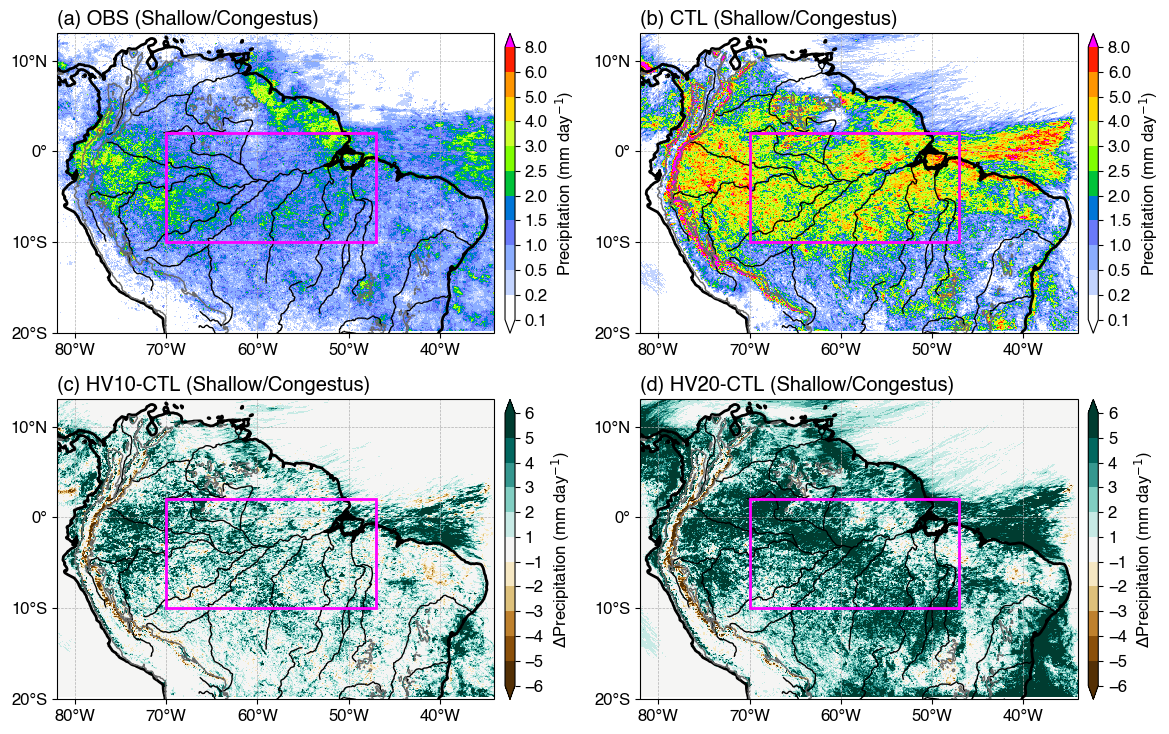

In [112]:
diff_m2_m1 = congpcp_all_m2 - congpcp_all_m1
diff_m3_m1 = congpcp_all_m3 - congpcp_all_m1
dataarray = [
    [congpcp_all_obs, congpcp_all_m1], 
    [diff_m2_m1, diff_m3_m1],
]
levels = [0.1,0.2,0.5,1,1.5,2,2.5,3,4,5,6,8]
levelsdiff = np.arange(-6,6.1,1)
# Remove mid-point (0 value)
idx = int((len(levelsdiff)-1)/2)
levelsdiff = np.delete(levelsdiff, idx)
levels = [[levels, levels], [levelsdiff,levelsdiff]]
cmap = generate_NCL_cmap('precip3_16lev', cont_opt=True, cont_param_n=16, cont_param_ws='sRGB')
cmapdiff = copy.copy(mpl.colormaps.get_cmap('BrBG'))
cmaps = [[cmap,cmap], [cmapdiff,cmapdiff]]
titles = [[f'(a) OBS (Shallow/Congestus)', f'(b) CTL (Shallow/Congestus)'], [f'(c) HV10-CTL (Shallow/Congestus)', f'(d) HV20-CTL (Shallow/Congestus)']]
cblabels = [['Precipitation (mm day$^{-1}$)','Precipitation (mm day$^{-1}$)'],
            [r'$\Delta$'+'Precipitation (mm day$^{-1}$)',r'$\Delta$'+'Precipitation (mm day$^{-1}$)']]
cbticks = levels
figname = f'{figdir}map_congestus_rainamount_obs_ctl_hv10_hv20.png'
oob_colors = {'under':'white', 'over':'magenta'}
fig = plot_map_mxn(2, 2, dataarray, lon, lat, levels, cmaps, titles, cblabels, cbticks, figname, 
                   figsize=[12,7.5], oob_colors=oob_colors, boxes=boxes)

## Frequency

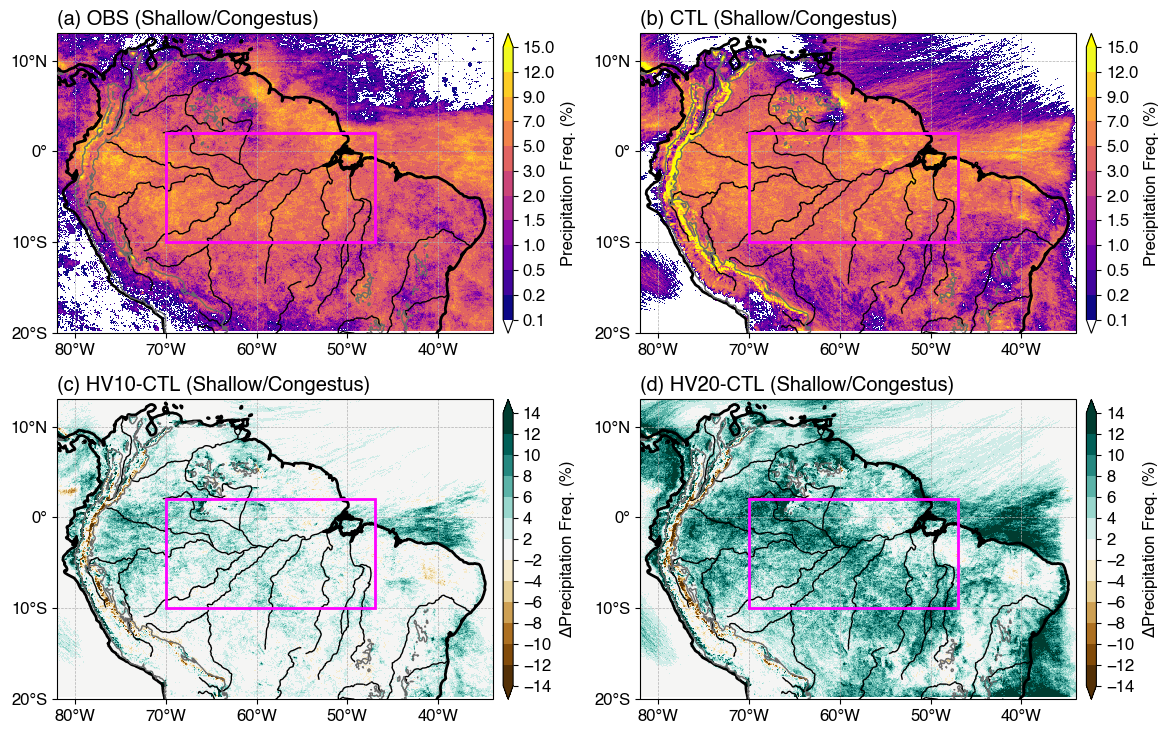

In [113]:
diff_m2_m1 = congpcpfreq_all_m2 - congpcpfreq_all_m1
diff_m3_m1 = congpcpfreq_all_m3 - congpcpfreq_all_m1
dataarray = [
    [congpcpfreq_all_obs, congpcpfreq_all_m1], 
    [diff_m2_m1, diff_m3_m1],
]
levels = [0.1,0.2,0.5,1,1.5,2,3,5,7,9,12,15]
levelsdiff = np.arange(-14,14.1,2)
# Remove mid-point (0 value)
idx = int((len(levelsdiff)-1)/2)
levelsdiff = np.delete(levelsdiff, idx)
levels = [[levels, levels], [levelsdiff,levelsdiff]]
cmap = 'plasma'
cmapdiff = copy.copy(mpl.colormaps.get_cmap('BrBG'))
cmaps = [[cmap,cmap], [cmapdiff,cmapdiff]]
titles = [[f'(a) OBS (Shallow/Congestus)', f'(b) CTL (Shallow/Congestus)'], [f'(c) HV10-CTL (Shallow/Congestus)', f'(d) HV20-CTL (Shallow/Congestus)']]
cblabels = [['Precipitation Freq. (%)','Precipitation Freq. (%)'],
            [r'$\Delta$'+'Precipitation Freq. (%)',r'$\Delta$'+'Precipitation Freq. (%)']]
cbticks = levels
figname = f'{figdir}map_congestus_rainfreq_obs_ctl_hv10_hv20.png'
oob_colors = {'under':'white', 'over':'yellow'}
fig = plot_map_mxn(2, 2, dataarray, lon, lat, levels, cmaps, titles, cblabels, cbticks, figname, 
                   figsize=[12,7.5], oob_colors=oob_colors, boxes=boxes)

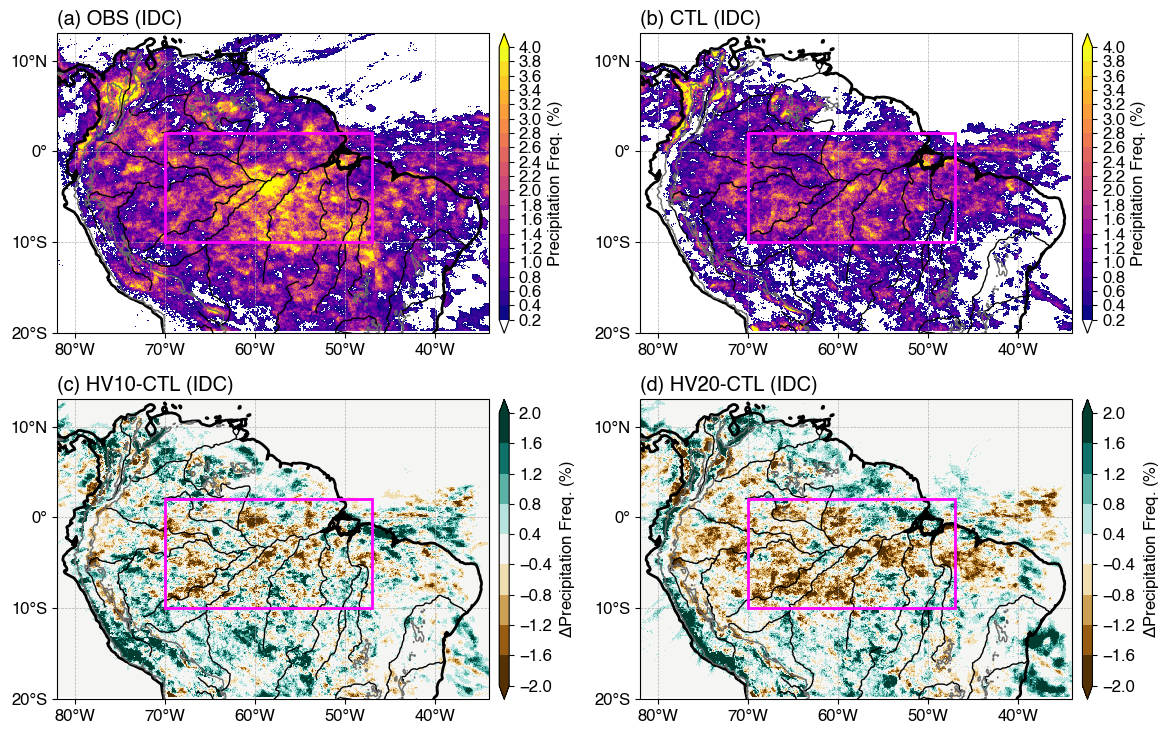

In [114]:
diff_m2_m1 = idcpcpfreq_all_m2 - idcpcpfreq_all_m1
diff_m3_m1 = idcpcpfreq_all_m3 - idcpcpfreq_all_m1
dataarray = [
    [idcpcpfreq_all_obs, idcpcpfreq_all_m1], 
    [diff_m2_m1, diff_m3_m1],
]
# levels = [0.1,0.2,0.5,1,1.5,2,3,5,7,9,12,15]
levels = np.arange(0.2, 4.01, 0.2) 
levelsdiff = np.arange(-2,2.1,0.4)
# Remove mid-point (0 value)
idx = int((len(levelsdiff)-1)/2)
levelsdiff = np.delete(levelsdiff, idx)
levels = [[levels, levels], [levelsdiff,levelsdiff]]
cmap = 'plasma'
cmapdiff = copy.copy(mpl.colormaps.get_cmap('BrBG'))
cmaps = [[cmap,cmap], [cmapdiff,cmapdiff]]
titles = [[f'(a) OBS (IDC)', f'(b) CTL (IDC)'], [f'(c) HV10-CTL (IDC)', f'(d) HV20-CTL (IDC)']]
cblabels = [['Precipitation Freq. (%)','Precipitation Freq. (%)'],
            [r'$\Delta$'+'Precipitation Freq. (%)',r'$\Delta$'+'Precipitation Freq. (%)']]
cbticks = levels
figname = f'{figdir}map_idc_rainfreq_obs_ctl_hv10_hv20.png'
oob_colors = {'under':'white', 'over':'yellow'}
fig = plot_map_mxn(2, 2, dataarray, lon, lat, levels, cmaps, titles, cblabels, cbticks, figname, 
                   figsize=[12,7.5], oob_colors=oob_colors, boxes=boxes)

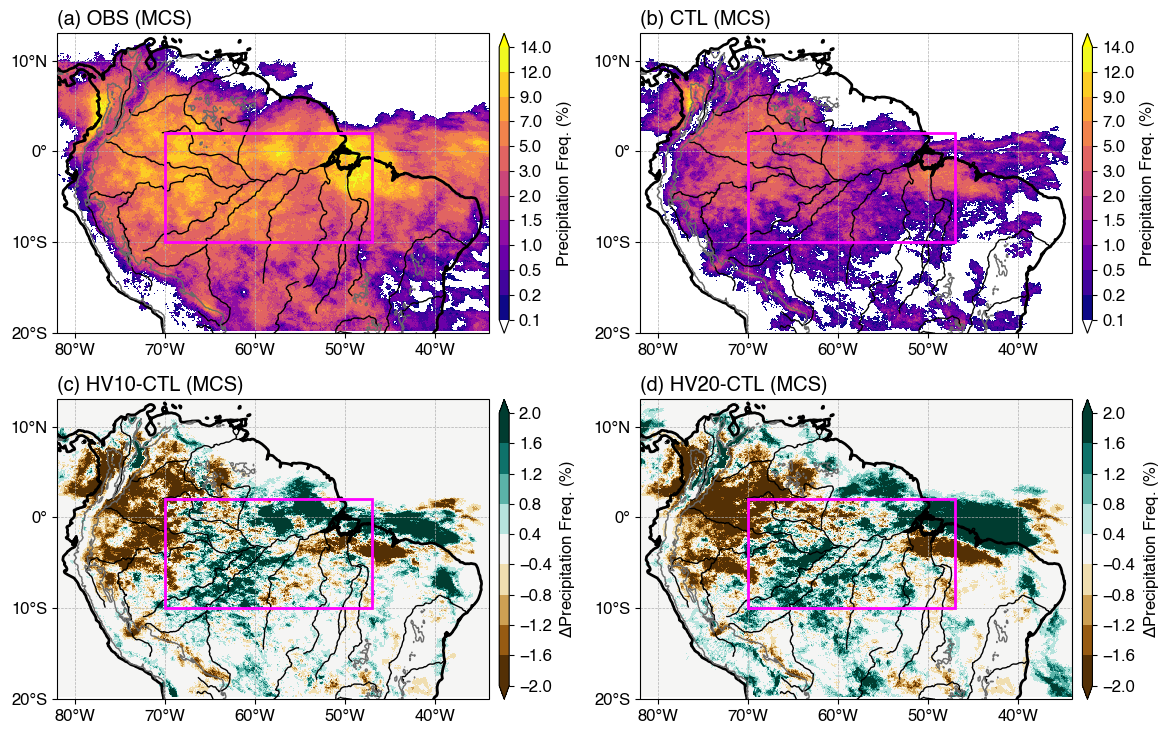

In [115]:
diff_m2_m1 = mcspcpfreq_all_m2 - mcspcpfreq_all_m1
diff_m3_m1 = mcspcpfreq_all_m3 - mcspcpfreq_all_m1
dataarray = [
    [mcspcpfreq_all_obs, mcspcpfreq_all_m1], 
    [diff_m2_m1, diff_m3_m1],
]
levels = [0.1,0.2,0.5,1,1.5,2,3,5,7,9,12,14]
# levelsdiff = np.arange(-5,5.1,0.5)
levelsdiff = np.arange(-2,2.1,0.4)
# Remove mid-point (0 value)
idx = int((len(levelsdiff)-1)/2)
levelsdiff = np.delete(levelsdiff, idx)
levels = [[levels, levels], [levelsdiff,levelsdiff]]
cmap = 'plasma'
cmapdiff = copy.copy(mpl.colormaps.get_cmap('BrBG'))
cmaps = [[cmap,cmap], [cmapdiff,cmapdiff]]
titles = [[f'(a) OBS (MCS)', f'(b) CTL (MCS)'], [f'(c) HV10-CTL (MCS)', f'(d) HV20-CTL (MCS)']]
cblabels = [['Precipitation Freq. (%)','Precipitation Freq. (%)'],
            [r'$\Delta$'+'Precipitation Freq. (%)',r'$\Delta$'+'Precipitation Freq. (%)']]
cbticks = levels
figname = f'{figdir}map_mcs_rainfreq_obs_ctl_hv10_hv20.png'
oob_colors = {'under':'white', 'over':'yellow'}
fig = plot_map_mxn(2, 2, dataarray, lon, lat, levels, cmaps, titles, cblabels, cbticks, figname, 
                   figsize=[12,7.5], oob_colors=oob_colors, boxes=boxes)

## Intensity

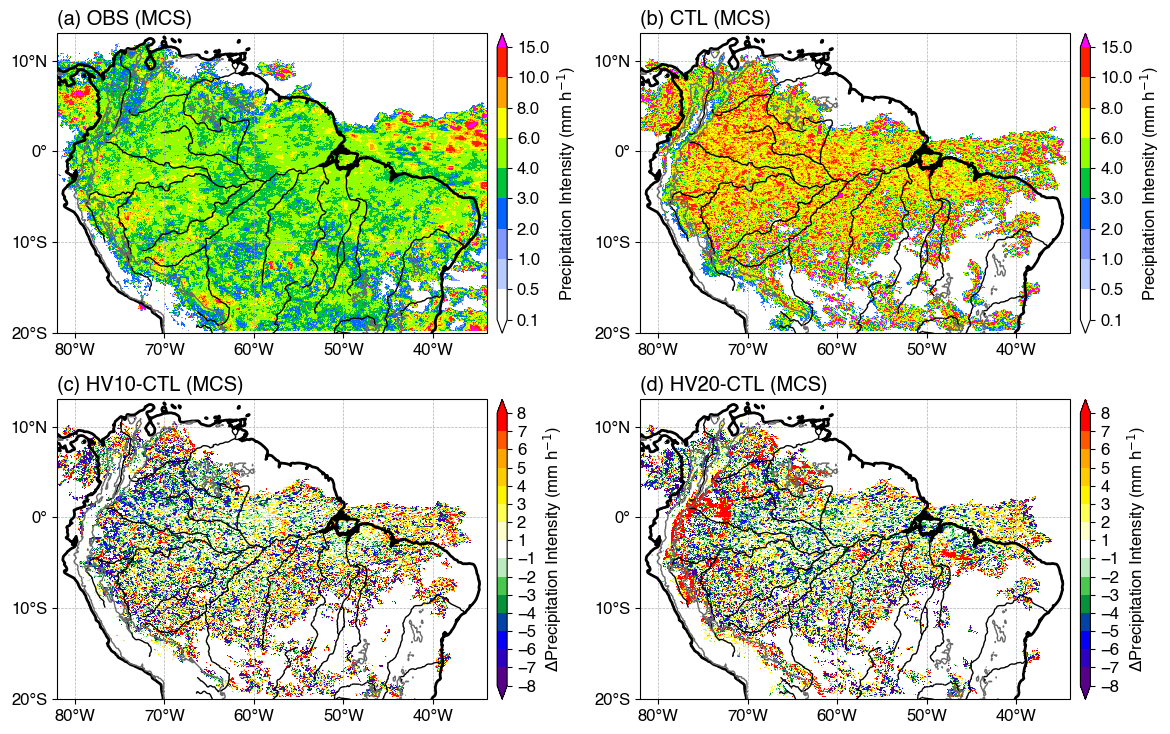

In [85]:
min_freq = 0.1
diff_m2_m1 = mcspcpintensity_all_m2 - mcspcpintensity_all_m1
diff_m3_m1 = mcspcpintensity_all_m3 - mcspcpintensity_all_m1
dataarray = [
    [mcspcpintensity_all_obs.where(mcspcpfreq_all_obs > min_freq), mcspcpintensity_all_m1.where(mcspcpfreq_all_m1 > min_freq)], 
    [diff_m2_m1.where(mcspcpfreq_all_m1 > min_freq), diff_m3_m1.where(mcspcpfreq_all_m1 > min_freq)],
]
levels = [0.1,0.5,1,2,3,4,6,8,10,15]
levelsdiff = np.arange(-8,8.1,1)
# Remove mid-point (0 value)
idx = int((len(levelsdiff)-1)/2)
levelsdiff = np.delete(levelsdiff, idx)
levels = [[levels, levels], [levelsdiff,levelsdiff]]
cmap = generate_NCL_cmap('precip3_16lev', cont_opt=True, cont_param_n=16, cont_param_ws='sRGB')
cmapdiff = generate_NCL_cmap('ViBlGrWhYeOrRe', cont_opt=False, cont_param_n=0, cont_param_ws='sRGB', reverse_cmap=False)
cmaps = [[cmap,cmap], [cmapdiff,cmapdiff]]
titles = [[f'(a) OBS (MCS)', f'(b) CTL (MCS)'], [f'(c) HV10-CTL (MCS)', f'(d) HV20-CTL (MCS)']]
cblabels = [['Precipitation Intensity (mm h$^{-1}$)','Precipitation Intensity (mm h$^{-1}$)'],
            [r'$\Delta$'+'Precipitation Intensity (mm h$^{-1}$)',r'$\Delta$'+'Precipitation Intensity (mm h$^{-1}$)']]
cbticks = levels
figname = f'{figdir}map_mcs_rainintensity_obs_ctl_hv10_hv20.png'
oob_colors = {'under':'white', 'over':'magenta'}
fig = plot_map_mxn(2, 2, dataarray, lon, lat, levels, cmaps, titles, cblabels, cbticks, figname, figsize=[12,7.5], oob_colors=oob_colors)

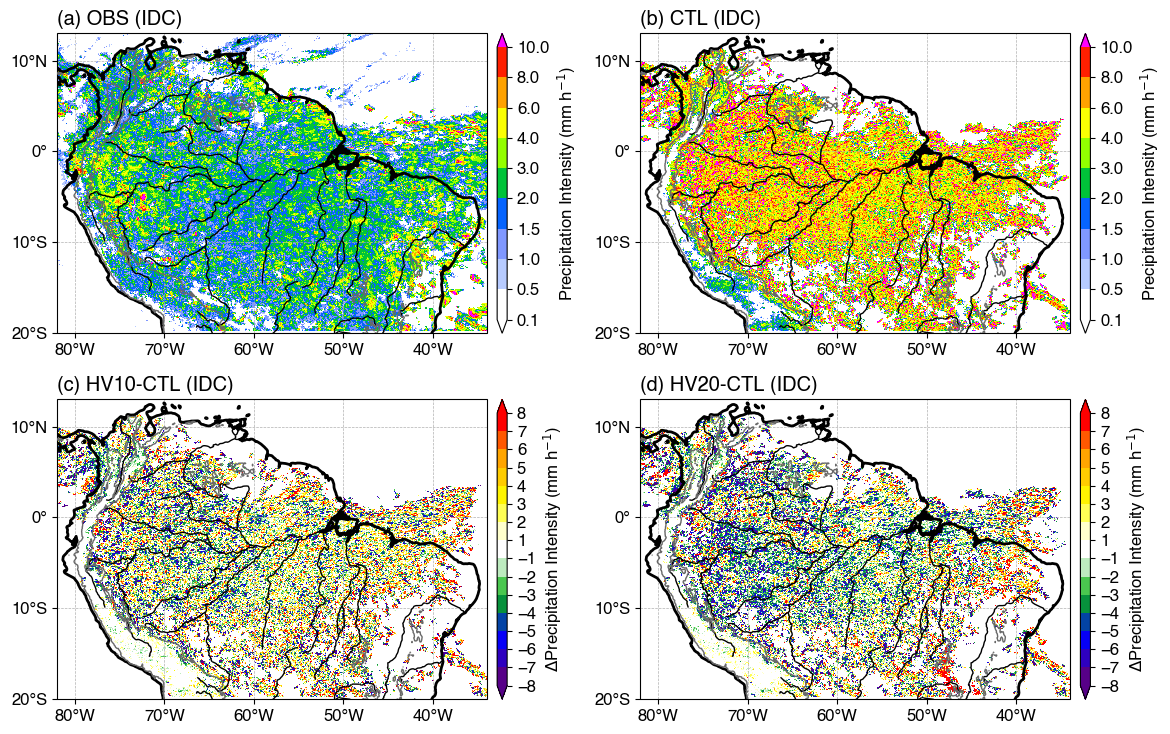

In [86]:
min_freq = 0.2
diff_m2_m1 = idcpcpintensity_all_m2 - idcpcpintensity_all_m1
diff_m3_m1 = idcpcpintensity_all_m3 - idcpcpintensity_all_m1
dataarray = [
    [idcpcpintensity_all_obs.where(idcpcpfreq_all_obs > min_freq), idcpcpintensity_all_m1.where(idcpcpfreq_all_m1 > min_freq)], 
    [diff_m2_m1.where(idcpcpfreq_all_m1 > min_freq), diff_m3_m1.where(idcpcpfreq_all_m1 > min_freq)],
]
levels = [0.1,0.5,1,1.5,2,3,4,6,8,10]
levelsdiff = np.arange(-8,8.1,1)
# Remove mid-point (0 value)
idx = int((len(levelsdiff)-1)/2)
levelsdiff = np.delete(levelsdiff, idx)
levels = [[levels, levels], [levelsdiff,levelsdiff]]
cmap = generate_NCL_cmap('precip3_16lev', cont_opt=True, cont_param_n=16, cont_param_ws='sRGB')
cmapdiff = generate_NCL_cmap('ViBlGrWhYeOrRe', cont_opt=False, cont_param_n=0, cont_param_ws='sRGB', reverse_cmap=False)
cmaps = [[cmap,cmap], [cmapdiff,cmapdiff]]
titles = [[f'(a) OBS (IDC)', f'(b) CTL (IDC)'], [f'(c) HV10-CTL (IDC)', f'(d) HV20-CTL (IDC)']]
cblabels = [['Precipitation Intensity (mm h$^{-1}$)','Precipitation Intensity (mm h$^{-1}$)'],
            [r'$\Delta$'+'Precipitation Intensity (mm h$^{-1}$)',r'$\Delta$'+'Precipitation Intensity (mm h$^{-1}$)']]
cbticks = levels
figname = f'{figdir}map_idc_rainintensity_obs_ctl_hv10_hv20.png'
oob_colors = {'under':'white', 'over':'magenta'}
fig = plot_map_mxn(2, 2, dataarray, lon, lat, levels, cmaps, titles, cblabels, cbticks, figname, figsize=[12,7.5], oob_colors=oob_colors)

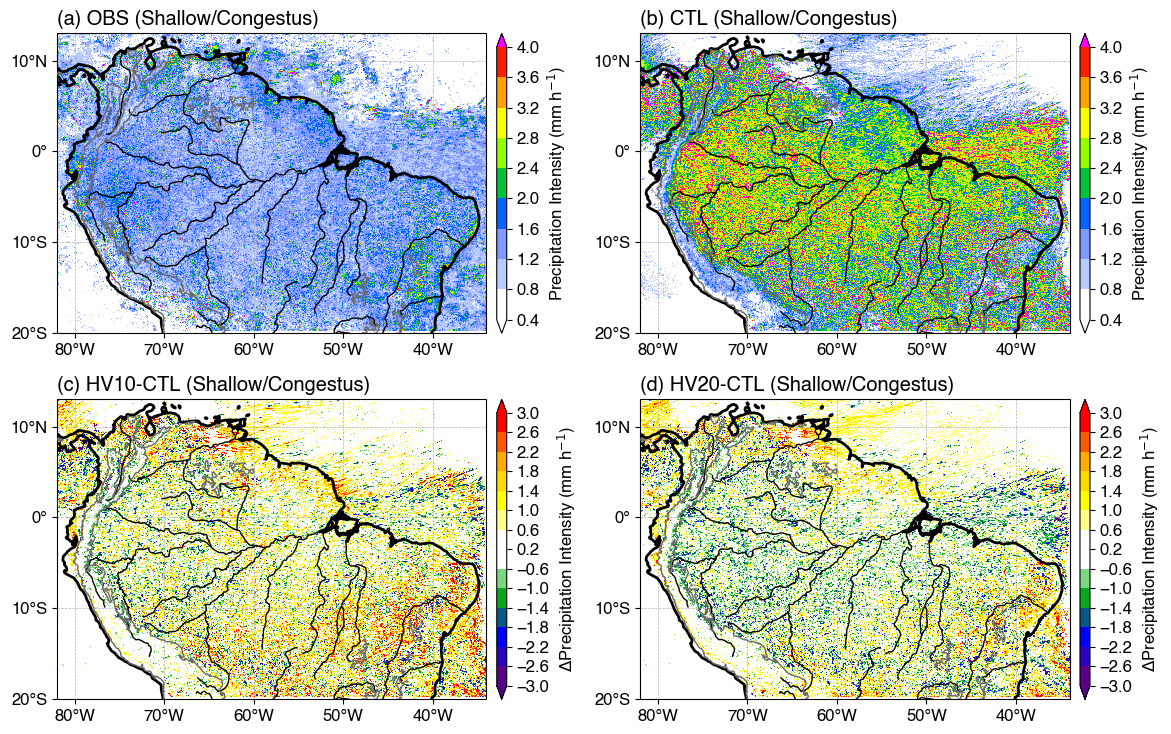

In [87]:
min_freq = 0.1
diff_m2_m1 = congpcpintensity_all_m2 - congpcpintensity_all_m1
diff_m3_m1 = congpcpintensity_all_m3 - congpcpintensity_all_m1
dataarray = [
    [congpcpintensity_all_obs.where(congpcpfreq_all_obs > min_freq), congpcpintensity_all_m1.where(congpcpfreq_all_m1 > min_freq)], 
    [diff_m2_m1.where(congpcpfreq_all_m1 > min_freq), diff_m3_m1.where(congpcpfreq_all_m1 > min_freq)],
]
levels = np.arange(0.4, 4.01, 0.4)
levelsdiff = np.arange(-3,3.1,0.4)
# Remove mid-point (0 value)
idx = int((len(levelsdiff)-1)/2)
levelsdiff = np.delete(levelsdiff, idx)
levels = [[levels, levels], [levelsdiff,levelsdiff]]
cmap = generate_NCL_cmap('precip3_16lev', cont_opt=True, cont_param_n=16, cont_param_ws='sRGB')
cmapdiff = generate_NCL_cmap('ViBlGrWhYeOrRe', cont_opt=False, cont_param_n=0, cont_param_ws='sRGB', reverse_cmap=False)
cmaps = [[cmap,cmap], [cmapdiff,cmapdiff]]
titles = [[f'(a) OBS (Shallow/Congestus)', f'(b) CTL (Shallow/Congestus)'], [f'(c) HV10-CTL (Shallow/Congestus)', f'(d) HV20-CTL (Shallow/Congestus)']]
cblabels = [['Precipitation Intensity (mm h$^{-1}$)','Precipitation Intensity (mm h$^{-1}$)'],
            [r'$\Delta$'+'Precipitation Intensity (mm h$^{-1}$)',r'$\Delta$'+'Precipitation Intensity (mm h$^{-1}$)']]
cbticks = levels
figname = f'{figdir}map_congestus_rainintensity_obs_ctl_hv10_hv20.png'
oob_colors = {'under':'white', 'over':'magenta'}
fig = plot_map_mxn(2, 2, dataarray, lon, lat, levels, cmaps, titles, cblabels, cbticks, figname, figsize=[12,7.5], oob_colors=oob_colors)

In [81]:
figdir

'/global/cfs/cdirs/m1657/zfeng/amazon_hvmixing/figures/'